In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data',train= True, download= True, transform = transform)

In [4]:
test_data = datasets.MNIST(root='../Data',train= False, download= True, transform = transform)

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data,batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)


In [7]:
# 1 gray scale, 6 filter output channel feature, 3 by 3 kernel size, stride = 1 (how big)
conv1 = nn.Conv2d(1,6,3,1) # ---> 6 filters ---> pooling ---> conv2

# 6 input filter Conv1, 16 filters, 3 by 3, stride = 1
conv2 = nn.Conv2d(6,16,3,1) 

In [8]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [9]:
X_train.shape # ---> 4D batch(batch of 1 image)

torch.Size([1, 28, 28])

In [10]:
x = X_train.view(1,1,28,28)

In [11]:
x= F.relu(conv1(x))

In [12]:
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
x= F.max_pool2d(x,2,2)

In [16]:
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
(((28-2)/2)-2)/2

5.5

In [22]:
x.shape #10

torch.Size([1, 16, 5, 5])

In [24]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [26]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [27]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [32]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [33]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [35]:
import time
start_time = time.time()


# Variables(trackers)

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCH

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches (train)
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 or False 0 sum()
        trn_corr += batch_corr
        
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04055629  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08253470  accuracy:  85.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.36470515  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01839541  accuracy:  90.525%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00845350  accuracy:  91.687%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00152981  accuracy:  92.506%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.56773776  accuracy:  93.152%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02005105  accuracy:  93.615%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00804486  accuracy:  94.030%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03699137  accuracy:  94.340%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01467017  accuracy:  97.717%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.04897313  accuracy:  97.875%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00128244  accuracy:  97.906%
epoch:  1  b

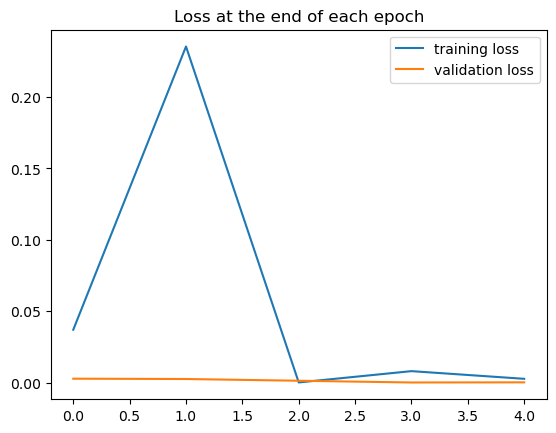

In [36]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [37]:
test_losses

[tensor(0.0027),
 tensor(0.0025),
 tensor(0.0013),
 tensor(3.4665e-05),
 tensor(0.0001)]

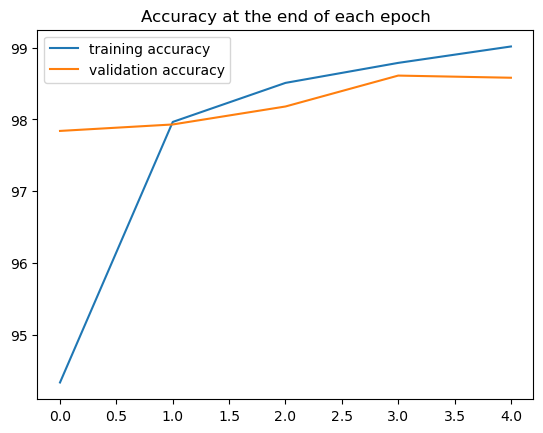

In [38]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [40]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [41]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9858/10000 =  98.580%


In [42]:
correct.item()/len(test_data)

0.9858

In [43]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 975    0    0    0    0    1    3    0    3    0]
 [   0 1133    1    0    0    1    2    6    0    1]
 [   0    1 1023    0    1    0    1    7    2    0]
 [   0    1    0 1004    0    6    0    0    1    3]
 [   0    0    1    0  978    0    1    2    2   24]
 [   0    0    0    3    0  877    3    0    2    5]
 [   4    0    0    0    2    2  947    0    1    1]
 [   1    0    5    1    0    1    0 1009    0    5]
 [   0    0    2    2    0    2    1    1  962   20]
 [   0    0    0    0    1    2    0    3    1  950]]


In [67]:
#Examine the misses
#We can track the index positions of "missed" predictions, and extract the corresponding image and label.
#We'll do this in batches to save screen space.

misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

142

In [68]:
# Display the first 10 index positions
misses[:10]

array([ 235,  247,  273,  320,  340,  359,  417,  445,  448,  495],
      dtype=int64)

In [69]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 691  813  926  938  947  992 1014 1021 1032 1039 1107 1112]
Label: [   8    9    2    3    8    9    6    7    5    7    9    4]
Guess: [   4    8    8    5    9    8    5    2    6    1    3    6]


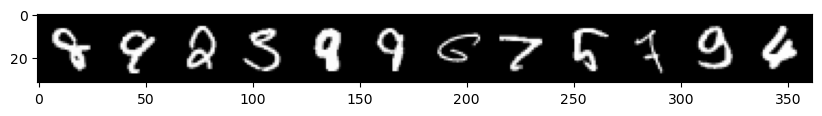

In [72]:
# Now that everything is set up, run and re-run the cell below to view all of the missed predictions.

nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

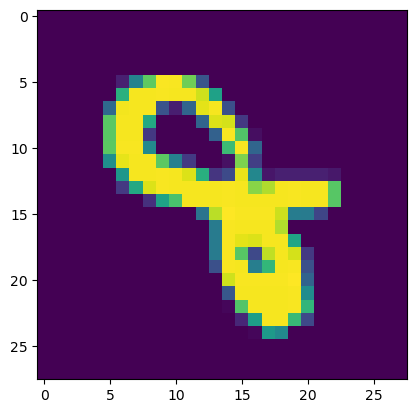

In [73]:
plt.imshow(test_data[691][0].reshape(28,28))

In [74]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[691][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 4
